In [2]:
'Test_Task1 seat or carrier seat Classification using XG Boost model and MLP model'

'Test_Task1 seat or carrier seat Classification using XG Boost model and MLP model'

In [4]:
import gc
gc.collect()

3127

In [6]:
%reset -f

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

# Test measurements

In [11]:
import numpy as np
import pandas as pd

file_path = 'Emptyseat_npy_array_Lowpassfiltered_label.npy'

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Now 'loaded_array' contains the NumPy array data that was saved in the file
dataframe_testdata = pd.DataFrame(loaded_array,columns=['Frequency','FFT Magnitude','Phase','Object_Presence'])
dataframe_testdata = dataframe_testdata.iloc[:2000]
#dataframe_testdata = dataframe_testdata.sample(n=2000, random_state=42)
dataframe_testdata


,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
1995,184318.087748,1861.428549,1.843221,0.0
1996,184410.477767,1579.966739,-1.664529,0.0
1997,184502.867786,1454.030087,1.316335,0.0
1998,184595.257805,1071.823782,-1.769977,0.0


In [12]:
num_rows_test = len(dataframe_testdata)
num_rows_test

2000

In [13]:
fft_magnitudes_test = dataframe_testdata["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_test

array([88895.47997562, 42749.87597587,  3517.83133451, ...,
        1454.0300868 ,  1071.82378202,   580.06858035], shape=(2000,))

In [14]:
fft_frequencies_test = dataframe_testdata["Frequency"].values  # Convert to NumPy array
fft_frequencies_test

array([0.00000000e+00, 9.23900189e+01, 1.84780038e+02, ...,
       1.84502868e+05, 1.84595258e+05, 1.84687648e+05], shape=(2000,))

In [15]:
fft_phase_test = dataframe_testdata["Phase"].values  # Convert to NumPy array
fft_phase_test

array([ 0.        ,  3.1140803 , -2.62505464, ...,  1.31633468,
       -1.76997733,  0.95328259], shape=(2000,))

In [16]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks

def extract_features(fft_freqs, fft_mags, fft_phase):
    # Normalize magnitudes to prevent division errors
    norm_mags = fft_mags / np.sum(fft_mags) if np.sum(fft_mags) > 0 else fft_mags
    
    # Spectral Centroid (Weighted Mean of Frequencies)
    spectral_centroid = np.sum(fft_freqs * norm_mags) / np.sum(norm_mags)

    # Spectral Bandwidth (Spread around centroid)
    spectral_bandwidth = np.sqrt(np.sum(norm_mags * (fft_freqs - spectral_centroid) ** 2))

    # Spectral Flatness (Geometric Mean / Arithmetic Mean)
    spectral_flatness = np.exp(np.mean(np.log(fft_mags + 1e-10))) / np.mean(fft_mags + 1e-10)

    # Phase Features
    phase_variance = np.var(fft_phase)  # Variance of phase angles
    phase_mean = np.mean(fft_phase)  # Mean of phase angles
    phase_diff = np.mean(np.diff(fft_phase))  # Average phase difference between frequencies

    return {
        "mean_fft": np.mean(fft_mags),
        "std_fft": np.std(fft_mags),
        "max_fft": np.max(fft_mags),
        "min_fft": np.min(fft_mags),
        "median_fft": np.median(fft_mags),
        "sum_fft": np.sum(fft_mags),
        "spectral_entropy": entropy(norm_mags),  # Energy spread
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "phase_variance": phase_variance,
        "phase_mean": phase_mean,
        "phase_diff": phase_diff,
    }


In [18]:
# Function to apply perturbation based on reference values
def add_perturbation(reference_features, num_rows, perturb_range=0.03):
    perturbed_data = []
    
    for _ in range(num_rows):
        perturbed_features = {
            key: value * (1 + np.random.uniform(-perturb_range, perturb_range)) 
            for key, value in reference_features.items()
        }
        perturbed_data.append(perturbed_features)
    
    return pd.DataFrame(perturbed_data)

In [26]:
# Extract features for fft_test
reference_features_test = extract_features(fft_frequencies_test, fft_magnitudes_test, fft_phase_test)
reference_features_test

{'mean_fft': np.float64(854.4910739948114),
 'std_fft': np.float64(2228.962411816856),
 'max_fft': np.float64(88895.4799756217),
 'min_fft': np.float64(14.614978023022962),
 'median_fft': np.float64(719.071432470062),
 'sum_fft': np.float64(1708982.1479896228),
 'spectral_entropy': np.float64(7.184597679269629),
 'spectral_centroid': np.float64(81214.61702912196),
 'spectral_bandwidth': np.float64(55979.55212226324),
 'phase_variance': np.float64(3.256783134708977),
 'phase_mean': np.float64(0.0034921221066036914),
 'phase_diff': np.float64(0.00047687973400298604)}

In [30]:
# Generate a DataFrame with perturbed values for all rows in fft_test
num_rows_test = len(dataframe_testdata)
perturbed_test_df = add_perturbation(reference_features_test, num_rows_test, perturb_range=0.03)
perturbed_test_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,872.619460,2242.368221,88438.609232,14.364414,697.598649,1.722203e+06,7.311149,79075.128113,56825.343529,3.179418,0.003583,0.000466
1,842.546748,2267.544554,88192.889364,14.712240,718.733323,1.658056e+06,7.121442,80048.715749,56345.085806,3.340530,0.003566,0.000464
2,831.590203,2190.646193,90860.256299,14.255827,711.763734,1.667072e+06,7.224618,82441.699976,57514.145460,3.313509,0.003448,0.000467
3,875.154259,2276.142456,90798.025833,15.031719,711.379982,1.714404e+06,7.272895,83498.720632,55664.742622,3.215223,0.003391,0.000481
4,866.560115,2232.860184,86335.312447,14.196012,713.728609,1.693284e+06,7.356613,81982.174794,55496.552008,3.342222,0.003512,0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,852.584160,2275.970616,89975.035196,14.312452,726.578276,1.744767e+06,7.394275,80175.329970,56030.984180,3.273116,0.003491,0.000491
1996,863.759326,2284.780399,86532.786639,14.276191,732.412474,1.735652e+06,7.361510,80923.231844,57545.700539,3.175825,0.003578,0.000468
1997,878.839329,2289.923310,87621.552231,14.543831,739.648887,1.690544e+06,7.160937,83572.947720,55070.639803,3.346202,0.003568,0.000483
1998,876.174086,2209.941370,89743.155744,14.266117,734.898241,1.700339e+06,7.351420,81541.707689,54467.901024,3.281299,0.003396,0.000490


In [33]:
dataframe_testdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
1995,184318.087748,1861.428549,1.843221,0.0
1996,184410.477767,1579.966739,-1.664529,0.0
1997,184502.867786,1454.030087,1.316335,0.0
1998,184595.257805,1071.823782,-1.769977,0.0


In [35]:
len(perturbed_test_df),len(dataframe_testdata)

(2000, 2000)

In [37]:
# Ensure both DataFrames have the same number of rows
if len(dataframe_testdata) != len(perturbed_test_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_testdata_withfeatures = pd.concat([dataframe_testdata, perturbed_test_df], axis=1)

# Display the first few rows of the updated dataframe_testdata to verify
dataframe_testdata_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,872.619460,2242.368221,88438.609232,14.364414,697.598649,1.722203e+06,7.311149,79075.128113,56825.343529,3.179418,0.003583,0.000466
1,92.390019,42749.875976,3.114080,0.0,842.546748,2267.544554,88192.889364,14.712240,718.733323,1.658056e+06,7.121442,80048.715749,56345.085806,3.340530,0.003566,0.000464
2,184.780038,3517.831335,-2.625055,0.0,831.590203,2190.646193,90860.256299,14.255827,711.763734,1.667072e+06,7.224618,82441.699976,57514.145460,3.313509,0.003448,0.000467
3,277.170057,2235.324771,0.837800,0.0,875.154259,2276.142456,90798.025833,15.031719,711.379982,1.714404e+06,7.272895,83498.720632,55664.742622,3.215223,0.003391,0.000481
4,369.560076,1569.457500,-1.524020,0.0,866.560115,2232.860184,86335.312447,14.196012,713.728609,1.693284e+06,7.356613,81982.174794,55496.552008,3.342222,0.003512,0.000487


In [39]:
len(dataframe_testdata_withfeatures)

2000

In [41]:
dataframe_testdata_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,872.619460,2242.368221,88438.609232,14.364414,697.598649,1.722203e+06,7.311149,79075.128113,56825.343529,3.179418,0.003583,0.000466
1,92.390019,42749.875976,3.114080,0.0,842.546748,2267.544554,88192.889364,14.712240,718.733323,1.658056e+06,7.121442,80048.715749,56345.085806,3.340530,0.003566,0.000464
2,184.780038,3517.831335,-2.625055,0.0,831.590203,2190.646193,90860.256299,14.255827,711.763734,1.667072e+06,7.224618,82441.699976,57514.145460,3.313509,0.003448,0.000467
3,277.170057,2235.324771,0.837800,0.0,875.154259,2276.142456,90798.025833,15.031719,711.379982,1.714404e+06,7.272895,83498.720632,55664.742622,3.215223,0.003391,0.000481
4,369.560076,1569.457500,-1.524020,0.0,866.560115,2232.860184,86335.312447,14.196012,713.728609,1.693284e+06,7.356613,81982.174794,55496.552008,3.342222,0.003512,0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,184318.087748,1861.428549,1.843221,0.0,852.584160,2275.970616,89975.035196,14.312452,726.578276,1.744767e+06,7.394275,80175.329970,56030.984180,3.273116,0.003491,0.000491
1996,184410.477767,1579.966739,-1.664529,0.0,863.759326,2284.780399,86532.786639,14.276191,732.412474,1.735652e+06,7.361510,80923.231844,57545.700539,3.175825,0.003578,0.000468
1997,184502.867786,1454.030087,1.316335,0.0,878.839329,2289.923310,87621.552231,14.543831,739.648887,1.690544e+06,7.160937,83572.947720,55070.639803,3.346202,0.003568,0.000483
1998,184595.257805,1071.823782,-1.769977,0.0,876.174086,2209.941370,89743.155744,14.266117,734.898241,1.700339e+06,7.351420,81541.707689,54467.901024,3.281299,0.003396,0.000490


In [ ]:
# You can directly test whether the model is predicting this set of data as true or not by running it through loaded model 
# You can skip the second half of the dateset and start from the dropping features section

# Carrierseat data

In [45]:
import numpy as np
import pandas as pd
# Replace 'your_array_file.npy' with the actual file path of your saved NumPy array
file_path = 'test_Carrierseat_withoutbaby_npy_array_Lowpassfiltered_withlabel_1.npy'

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Now 'loaded_array' contains the NumPy array data that was saved in the file
dataframe_carrierseat = pd.DataFrame(loaded_array,columns=['Frequency','FFT Magnitude','Phase','Object_Presence'])
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,16732.464039,0.000000,1.0
1,488.28125,8333.605309,3.112956,1.0
2,976.56250,204.398557,-1.629384,1.0
3,1464.84375,124.749508,1.244306,1.0
4,1953.12500,218.879548,-2.558848,1.0
...,...,...,...,...
3995,-2441.40625,112.613316,-0.375541,1.0
3996,-1953.12500,218.879548,2.558848,1.0
3997,-1464.84375,124.749508,-1.244306,1.0
3998,-976.56250,204.398557,1.629384,1.0


In [47]:
fft_magnitudes_carrier = dataframe_carrierseat["FFT Magnitude"].values  # Convert to NumPy array
fft_frequencies_carrier = dataframe_carrierseat["Frequency"].values  # Convert to NumPy array
fft_phase_carrier = dataframe_carrierseat["Phase"].values  # Convert to NumPy array


In [49]:
# Extract features for fft_carrier
reference_features_carrier = extract_features(fft_frequencies_carrier, fft_magnitudes_carrier, fft_phase_carrier)
reference_features_carrier

{'mean_fft': np.float64(325.95225423295017),
 'std_fft': np.float64(378.9192634886786),
 'max_fft': np.float64(16732.464038774917),
 'min_fft': np.float64(8.289574826003792),
 'median_fft': np.float64(275.93543287593525),
 'sum_fft': np.float64(1303809.0169318006),
 'spectral_entropy': np.float64(8.0351420470818),
 'spectral_centroid': np.float64(-70.97002611338394),
 'spectral_bandwidth': np.float64(579371.9519415188),
 'phase_variance': np.float64(3.2899656084123654),
 'phase_mean': np.float64(5.3290705182007515e-18),
 'phase_diff': np.float64(-0.0007784337064980223)}

In [51]:
# Generate a DataFrame with perturbed values for all rows in fft_empty
num_rows_carrier = len(dataframe_carrierseat)
perturbed_carrier_df = add_perturbation(reference_features_carrier, num_rows_carrier, perturb_range=0.03)
perturbed_carrier_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,326.884341,382.024116,16986.543839,8.307250,277.813511,1.310119e+06,7.795783,-70.623770,596330.402353,3.341366,5.327131e-18,-0.000794
1,333.284951,368.552402,16714.862208,8.473990,271.883325,1.323990e+06,7.947867,-72.133596,578944.408105,3.346375,5.260342e-18,-0.000766
2,332.231479,370.764907,16522.744106,8.315171,269.430123,1.273791e+06,8.057883,-69.214254,585998.223739,3.329385,5.279250e-18,-0.000756
3,330.572618,369.838155,16620.951361,8.420697,283.906603,1.282353e+06,8.124896,-72.961472,589650.990028,3.225502,5.251152e-18,-0.000769
4,326.731062,367.672770,16549.783258,8.237552,274.068491,1.315029e+06,7.992022,-72.200493,572654.257878,3.308534,5.381105e-18,-0.000769
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,324.615314,385.649207,16653.243471,8.469106,283.199153,1.338374e+06,8.028112,-70.888239,582501.738675,3.321767,5.292281e-18,-0.000791
3996,322.937668,381.073580,16860.993650,8.534140,268.092982,1.319613e+06,7.965627,-71.484049,583876.613405,3.316088,5.406845e-18,-0.000761
3997,317.413953,370.344979,16856.154313,8.079889,272.692184,1.313965e+06,8.259015,-71.421616,563442.109686,3.204548,5.420584e-18,-0.000785
3998,324.397972,378.265008,17020.483673,8.468157,268.791693,1.277008e+06,7.846160,-72.547884,587094.014655,3.327692,5.319392e-18,-0.000771


In [53]:
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,16732.464039,0.000000,1.0
1,488.28125,8333.605309,3.112956,1.0
2,976.56250,204.398557,-1.629384,1.0
3,1464.84375,124.749508,1.244306,1.0
4,1953.12500,218.879548,-2.558848,1.0
...,...,...,...,...
3995,-2441.40625,112.613316,-0.375541,1.0
3996,-1953.12500,218.879548,2.558848,1.0
3997,-1464.84375,124.749508,-1.244306,1.0
3998,-976.56250,204.398557,1.629384,1.0


In [55]:
len(perturbed_carrier_df),len(dataframe_carrierseat)

(4000, 4000)

In [57]:

# Ensure both DataFrames have the same number of rows
if len(dataframe_carrierseat) != len(perturbed_carrier_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_carrierseat_withfeatures = pd.concat([dataframe_carrierseat, perturbed_carrier_df], axis=1)

# Display the first few rows of the updated dataframe_emptyseat to verify
dataframe_carrierseat_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,16732.464039,0.000000,1.0,326.884341,382.024116,16986.543839,8.307250,277.813511,1.310119e+06,7.795783,-70.623770,596330.402353,3.341366,5.327131e-18,-0.000794
1,488.28125,8333.605309,3.112956,1.0,333.284951,368.552402,16714.862208,8.473990,271.883325,1.323990e+06,7.947867,-72.133596,578944.408105,3.346375,5.260342e-18,-0.000766
2,976.56250,204.398557,-1.629384,1.0,332.231479,370.764907,16522.744106,8.315171,269.430123,1.273791e+06,8.057883,-69.214254,585998.223739,3.329385,5.279250e-18,-0.000756
3,1464.84375,124.749508,1.244306,1.0,330.572618,369.838155,16620.951361,8.420697,283.906603,1.282353e+06,8.124896,-72.961472,589650.990028,3.225502,5.251152e-18,-0.000769
4,1953.12500,218.879548,-2.558848,1.0,326.731062,367.672770,16549.783258,8.237552,274.068491,1.315029e+06,7.992022,-72.200493,572654.257878,3.308534,5.381105e-18,-0.000769


In [ ]:
# Vertical concatenation
dataset_1_rawdata = pd.concat([dataframe_emptyseat,dataframe_carrierseat])
dataset_1_rawdata

In [ ]:
# Resetting the index if unique indices are needed
dataset_1_rawdata = dataset_1_rawdata.reset_index(drop=True)
dataset_1_rawdata

In [62]:
dataset_1_withfeatures = pd.concat([dataframe_testdata_withfeatures,dataframe_carrierseat_withfeatures])
dataset_1_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,872.619460,2242.368221,88438.609232,14.364414,697.598649,1.722203e+06,7.311149,79075.128113,56825.343529,3.179418,3.583161e-03,0.000466
1,92.390019,42749.875976,3.114080,0.0,842.546748,2267.544554,88192.889364,14.712240,718.733323,1.658056e+06,7.121442,80048.715749,56345.085806,3.340530,3.566425e-03,0.000464
2,184.780038,3517.831335,-2.625055,0.0,831.590203,2190.646193,90860.256299,14.255827,711.763734,1.667072e+06,7.224618,82441.699976,57514.145460,3.313509,3.448495e-03,0.000467
3,277.170057,2235.324771,0.837800,0.0,875.154259,2276.142456,90798.025833,15.031719,711.379982,1.714404e+06,7.272895,83498.720632,55664.742622,3.215223,3.391175e-03,0.000481
4,369.560076,1569.457500,-1.524020,0.0,866.560115,2232.860184,86335.312447,14.196012,713.728609,1.693284e+06,7.356613,81982.174794,55496.552008,3.342222,3.512290e-03,0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-2441.406250,112.613316,-0.375541,1.0,324.615314,385.649207,16653.243471,8.469106,283.199153,1.338374e+06,8.028112,-70.888239,582501.738675,3.321767,5.292281e-18,-0.000791
3996,-1953.125000,218.879548,2.558848,1.0,322.937668,381.073580,16860.993650,8.534140,268.092982,1.319613e+06,7.965627,-71.484049,583876.613405,3.316088,5.406845e-18,-0.000761
3997,-1464.843750,124.749508,-1.244306,1.0,317.413953,370.344979,16856.154313,8.079889,272.692184,1.313965e+06,8.259015,-71.421616,563442.109686,3.204548,5.420584e-18,-0.000785
3998,-976.562500,204.398557,1.629384,1.0,324.397972,378.265008,17020.483673,8.468157,268.791693,1.277008e+06,7.846160,-72.547884,587094.014655,3.327692,5.319392e-18,-0.000771


In [64]:
dataset_1_withfeatures = dataset_1_withfeatures.reset_index(drop=True)

In [66]:
dataframe_testdata_withfeatures = dataset_1_withfeatures

In [68]:
dataframe_testdata_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,872.619460,2242.368221,88438.609232,14.364414,697.598649,1.722203e+06,7.311149,79075.128113,56825.343529,3.179418,3.583161e-03,0.000466
1,92.390019,42749.875976,3.114080,0.0,842.546748,2267.544554,88192.889364,14.712240,718.733323,1.658056e+06,7.121442,80048.715749,56345.085806,3.340530,3.566425e-03,0.000464
2,184.780038,3517.831335,-2.625055,0.0,831.590203,2190.646193,90860.256299,14.255827,711.763734,1.667072e+06,7.224618,82441.699976,57514.145460,3.313509,3.448495e-03,0.000467
3,277.170057,2235.324771,0.837800,0.0,875.154259,2276.142456,90798.025833,15.031719,711.379982,1.714404e+06,7.272895,83498.720632,55664.742622,3.215223,3.391175e-03,0.000481
4,369.560076,1569.457500,-1.524020,0.0,866.560115,2232.860184,86335.312447,14.196012,713.728609,1.693284e+06,7.356613,81982.174794,55496.552008,3.342222,3.512290e-03,0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2441.406250,112.613316,-0.375541,1.0,324.615314,385.649207,16653.243471,8.469106,283.199153,1.338374e+06,8.028112,-70.888239,582501.738675,3.321767,5.292281e-18,-0.000791
5996,-1953.125000,218.879548,2.558848,1.0,322.937668,381.073580,16860.993650,8.534140,268.092982,1.319613e+06,7.965627,-71.484049,583876.613405,3.316088,5.406845e-18,-0.000761
5997,-1464.843750,124.749508,-1.244306,1.0,317.413953,370.344979,16856.154313,8.079889,272.692184,1.313965e+06,8.259015,-71.421616,563442.109686,3.204548,5.420584e-18,-0.000785
5998,-976.562500,204.398557,1.629384,1.0,324.397972,378.265008,17020.483673,8.468157,268.791693,1.277008e+06,7.846160,-72.547884,587094.014655,3.327692,5.319392e-18,-0.000771


# dropping features

In [71]:
# Resetting the index if unique indices are needed
dataframe_testdata_withfeatures = dataframe_testdata_withfeatures.reset_index(drop=True)
dataframe_testdata_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,872.619460,2242.368221,88438.609232,14.364414,697.598649,1.722203e+06,7.311149,79075.128113,56825.343529,3.179418,3.583161e-03,0.000466
1,92.390019,42749.875976,3.114080,0.0,842.546748,2267.544554,88192.889364,14.712240,718.733323,1.658056e+06,7.121442,80048.715749,56345.085806,3.340530,3.566425e-03,0.000464
2,184.780038,3517.831335,-2.625055,0.0,831.590203,2190.646193,90860.256299,14.255827,711.763734,1.667072e+06,7.224618,82441.699976,57514.145460,3.313509,3.448495e-03,0.000467
3,277.170057,2235.324771,0.837800,0.0,875.154259,2276.142456,90798.025833,15.031719,711.379982,1.714404e+06,7.272895,83498.720632,55664.742622,3.215223,3.391175e-03,0.000481
4,369.560076,1569.457500,-1.524020,0.0,866.560115,2232.860184,86335.312447,14.196012,713.728609,1.693284e+06,7.356613,81982.174794,55496.552008,3.342222,3.512290e-03,0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2441.406250,112.613316,-0.375541,1.0,324.615314,385.649207,16653.243471,8.469106,283.199153,1.338374e+06,8.028112,-70.888239,582501.738675,3.321767,5.292281e-18,-0.000791
5996,-1953.125000,218.879548,2.558848,1.0,322.937668,381.073580,16860.993650,8.534140,268.092982,1.319613e+06,7.965627,-71.484049,583876.613405,3.316088,5.406845e-18,-0.000761
5997,-1464.843750,124.749508,-1.244306,1.0,317.413953,370.344979,16856.154313,8.079889,272.692184,1.313965e+06,8.259015,-71.421616,563442.109686,3.204548,5.420584e-18,-0.000785
5998,-976.562500,204.398557,1.629384,1.0,324.397972,378.265008,17020.483673,8.468157,268.791693,1.277008e+06,7.846160,-72.547884,587094.014655,3.327692,5.319392e-18,-0.000771


In [73]:
to_drop = {'median_fft', 'sum_fft', 'min_fft', 'mean_fft', 'spectral_centroid', 'phase_mean'}
test_X = dataframe_testdata_withfeatures.drop(columns=['Object_Presence'])  # Features
test_y = dataframe_testdata_withfeatures['Object_Presence']  # Labels
test_x_dataset_1_reduced = test_X.drop(columns=to_drop)

In [75]:
test_x_dataset_1_reduced

,Frequency,FFT Magnitude,Phase,std_fft,max_fft,spectral_entropy,spectral_bandwidth,phase_variance,phase_diff
0,0.000000,88895.479976,0.000000,2242.368221,88438.609232,7.311149,56825.343529,3.179418,0.000466
1,92.390019,42749.875976,3.114080,2267.544554,88192.889364,7.121442,56345.085806,3.340530,0.000464
2,184.780038,3517.831335,-2.625055,2190.646193,90860.256299,7.224618,57514.145460,3.313509,0.000467
3,277.170057,2235.324771,0.837800,2276.142456,90798.025833,7.272895,55664.742622,3.215223,0.000481
4,369.560076,1569.457500,-1.524020,2232.860184,86335.312447,7.356613,55496.552008,3.342222,0.000487
...,...,...,...,...,...,...,...,...,...
5995,-2441.406250,112.613316,-0.375541,385.649207,16653.243471,8.028112,582501.738675,3.321767,-0.000791
5996,-1953.125000,218.879548,2.558848,381.073580,16860.993650,7.965627,583876.613405,3.316088,-0.000761
5997,-1464.843750,124.749508,-1.244306,370.344979,16856.154313,8.259015,563442.109686,3.204548,-0.000785
5998,-976.562500,204.398557,1.629384,378.265008,17020.483673,7.846160,587094.014655,3.327692,-0.000771


In [77]:
test_y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5995    1.0
5996    1.0
5997    1.0
5998    1.0
5999    1.0
Name: Object_Presence, Length: 6000, dtype: float64

# Testing the Xg Boost Model

In [81]:
import joblib
import xgboost as xgb

# Load the XGBoost model
clf = xgb.XGBClassifier()
clf.load_model('xgboost_model_Seat_classification.json')
scaler = joblib.load('xgboost_scaler_Seat_classification.pkl')

X_test_scaled = scaler.transform(test_x_dataset_1_reduced)

y_pred = clf.predict(X_test_scaled)
y_pred

array([0, 0, 0, ..., 1, 1, 1], shape=(6000,))

In [83]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2000
         1.0       1.00      1.00      1.00      4000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000


Confusion Matrix:
[[2000    0]
 [   0 4000]]


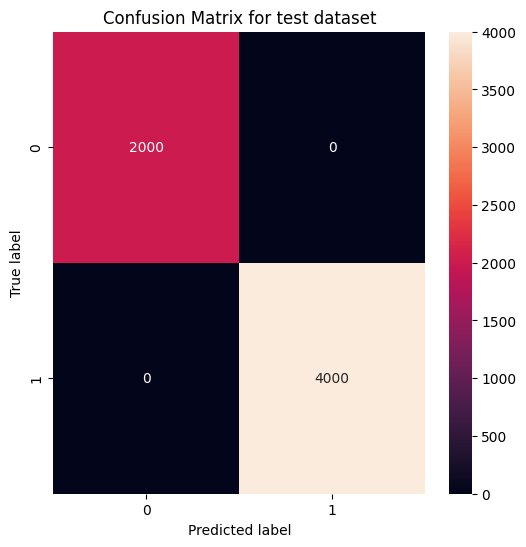

In [85]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()

###### 

# Testing with MLP model task 1

In [91]:
from tensorflow.keras.models import load_model
import joblib

# Load the trained MLP model
mlp_model = load_model('mlp_model_Seat_Classification.h5')

# Load the scaler
scaler = joblib.load('mlp_scaler_Seat_Classification.pkl')

# Example: Transform new data and make predictions
X_test_scaled = scaler.transform(test_x_dataset_1_reduced)

y_pred_prob = mlp_model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary (0 or 1)
y_pred




  1/188 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step

C:\Users\ANUSHRUTH\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


array([0, 0, 0, ..., 1, 1, 1], shape=(6000,))

In [92]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2000
         1.0       1.00      1.00      1.00      4000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000


Confusion Matrix:
[[2000    0]
 [   0 4000]]


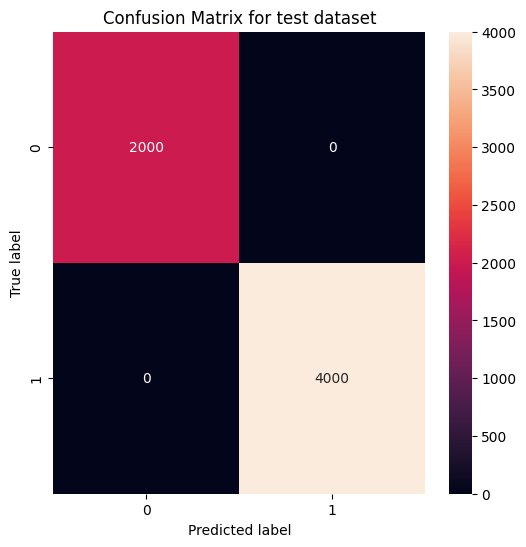

In [93]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()